In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import torch
import torch.nn as nn
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [28]:
!pip install yfinance

In [29]:
class RiskClassifier:
    def __init__(self):
        self.model = ExtraTreesClassifier(n_estimators=600, min_samples_leaf=2, random_state=42, n_jobs=-1)
        self.features = [
            "open", "high", "low", "close", "volume", "ema_50", "ema_200", "ema_gap",
            "macd", "macd_signal", "macd_diff", "rsi", "mfi", "volatility",
            "bollinger_hband", "bollinger_lband", "bollinger_pct", "return"
        ]

    def train(self, df_train_featured):
        df_train = df_train_featured.copy()
        
        # Gán nhãn rủi ro
        df_train["risk_label"] = np.select(
            [
                (df_train["volatility"] > df_train["q66"]), 
                (df_train["volatility"] <= df_train["q66"]) & (df_train["volatility"] > df_train["q33"]), 
                (df_train["volatility"] <= df_train["q33"]),
            ],
            [2, 1, 0], # [High, Medium, Low]
            default=np.nan 
        )
        df_train.dropna(subset=["risk_label"], inplace=True)
        
        X = df_train[self.features]
        y = df_train["risk_label"].astype(int)
        
        self.model.fit(X, y)
        print("[Risk Model] Huấn luyện xong")

    def predict(self, df_today_featured):
        if df_today_featured.empty:
            return pd.Series(dtype=int)

        
        X_today = df_today_featured[self.features].dropna()
        if X_today.empty:
            return pd.Series(dtype=int)
            
        predictions = self.model.predict(X_today)
        return pd.Series(predictions, index=X_today.index)




In [30]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_classes, num_layers=2, dropout=0.3):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, 
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.linear = nn.Linear(hidden_layer_size * 2, num_classes)

    def forward(self, input_seq):
        device = input_seq.device
        h0 = torch.zeros(self.num_layers * 2, input_seq.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, input_seq.size(0), self.hidden_layer_size).to(device)
        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

In [31]:
class SignalClassifier:
    def __init__(self, model_path, top_features, scaler_path,
                 time_steps=10, device="cpu"):
        self.model_path = model_path
        self.top_features = top_features
        self.scaler_path = scaler_path
        self.time_steps = time_steps
        self.device = device
        self.scaler = None
        self.model = None

    def load_model(self, input_size, num_classes=3, hidden_size=128):
        with open(self.scaler_path, "rb") as f:
            self.scaler = pickle.load(f)

        model = LSTMClassifier(input_size=input_size, hidden_layer_size=hidden_size, num_classes=num_classes)
        model.load_state_dict(torch.load(self.model_path, map_location=self.device))
        model.to(self.device)
        model.eval()
        self.model = model
        print(f"[Signal Model] Load weight từ {self.model_path} thành công")
        print(f"[Signal Model] Load scaler từ {self.scaler_path} thành công")

    def _create_lstm_dataset(self, X_scaled):
        if len(X_scaled) < self.time_steps:
            return np.array([])
        return X_scaled[-self.time_steps:].reshape(1, self.time_steps, X_scaled.shape[1])

    def predict(self, df_history_featured):
        if df_history_featured.empty or len(df_history_featured) < self.time_steps:
            return 1 

        X_hist = df_history_featured[self.top_features].values
        X_hist_scaled = self.scaler.transform(X_hist)

        X_lstm = self._create_lstm_dataset(X_hist_scaled)
        if X_lstm.shape[0] == 0:
            return 1 
        
        X_tensor = torch.tensor(X_lstm, dtype=torch.float32).to(self.device)

        with torch.no_grad():
            output = self.model(X_tensor)
            pred = torch.argmax(output, dim=1).item()
        
        return pred

In [32]:
def create_all_features(df, window_size=252):
    
    df_copy = df.copy()
    df_copy.sort_values(by=['ticker', 'timestamp'], inplace=True)
    
    # Features cho Risk Model
    denom = df_copy["ema_200"].replace(0, np.nan)
    df_copy["ema_gap"] = (df_copy["ema_50"] - df_copy["ema_200"]) / denom
    df_copy["volatility"] = df_copy.groupby("ticker")["return"].transform(lambda s: s.rolling(21).std() * np.sqrt(252))

    def rolling_quantile(s, quantile_val):
        return s.rolling(window=window_size, min_periods=window_size//2).quantile(quantile_val).shift(1)

    df_copy['q33'] = df_copy.groupby('ticker')['volatility'].transform(lambda s: rolling_quantile(s, 0.33))
    df_copy['q66'] = df_copy.groupby('ticker')['volatility'].transform(lambda s: rolling_quantile(s, 0.66))

    # Features cho Signal Model
    lags = [5, 10, 15]
    for lag in lags:
        df_copy[f'return_lag_{lag}'] = df_copy.groupby('ticker')['return'].shift(lag)
    vol_windows = [10, 20]
    for window in vol_windows:
        df_copy[f'volatility_{window}'] = df_copy.groupby('ticker')['return'].rolling(window=window).std().reset_index(0, drop=True)
    df_copy['rsi_momentum'] = df_copy.groupby('ticker')['rsi'].diff()
    df_copy['macd_diff_momentum'] = df_copy.groupby('ticker')['macd_diff'].diff()
    df_copy['price_vs_ema200'] = (df_copy['close'] / df_copy['ema_200']) - 1
    indicators_to_lag = ['rsi', 'mfi']
    for indicator in indicators_to_lag:
        for lag in [1, 3]:
            df_copy[f'{indicator}_lag_{lag}'] = df_copy.groupby('ticker')[indicator].shift(lag)
    
    print("Tạo features xong")
    return df_copy

In [33]:
def run_backtest(all_df, RiskClassifier, SignalClassifier,
                 risk_model_params={},
                 signal_model_params={},
                 initial_balance=1_000_000_000,
                 trailing_stop_percent=0.07):
    # --- B0: Feature Engineering ---
    all_df_featured = create_all_features(all_df)
    all_df_featured = all_df_featured.sort_values("timestamp").set_index("timestamp")

    # --- Chia train/test ---
    unique_dates = all_df_featured.index.unique().sort_values()
    split_idx = int(0.8 * len(unique_dates))
    train_cutoff = unique_dates[split_idx]
    train_df = all_df_featured.loc[all_df_featured.index <= train_cutoff]
    test_df = all_df_featured.loc[all_df_featured.index > train_cutoff]

    # --- Train Risk model ---
    risk_model = RiskClassifier(**risk_model_params)
    risk_model.train(train_df)

    # --- Load Signal model ---
    signal_model = SignalClassifier(**signal_model_params)
    input_size = len(signal_model.top_features)
    signal_model.load_model(input_size=input_size)

    trading_days = test_df.index.unique().sort_values()
    balance = initial_balance
    holdings = {}
    portfolio_history = []
    trade_log = []

    print("\nBẮT ĐẦU BACKTEST")
    for date in tqdm(trading_days, desc="Backtesting"):
        df_today_raw = test_df.loc[date]
        if isinstance(df_today_raw, pd.Series):
            df_today = df_today_raw.to_frame().T.set_index('ticker')
        else:
            df_today = df_today_raw.set_index('ticker')

        # Risk classification
        risk_preds = risk_model.predict(df_today)
        eligible_tickers = risk_preds[risk_preds.isin([0, 1])].index.tolist()
        if eligible_tickers:
             print(f"\n[{date.date()}] Các mã đủ điều kiện: {len(eligible_tickers)} - {eligible_tickers}")

        # Signal classification
        signals = {}
        for ticker in eligible_tickers:
            hist_data = all_df_featured[all_df_featured["ticker"] == ticker].loc[:date]
            signal = signal_model.predict(hist_data)
            signals[ticker] = signal
        if signals:
            buy_count = list(signals.values()).count(2)
            sell_count = list(signals.values()).count(0)
            hold_count = list(signals.values()).count(1)
            print(f" -> Tín hiệu: Mua: {buy_count}, Bán: {sell_count}, Giữ: {hold_count}")

        # Quản lý holdings
        current_holdings = list(holdings.keys())
        for ticker in current_holdings:
            if ticker in df_today.index:
                current_price = df_today.loc[ticker, "close"]
                new_ts = current_price * (1 - trailing_stop_percent)
                if new_ts > holdings[ticker]['trailing_stop']:
                    holdings[ticker]['trailing_stop'] = new_ts
                signal_for_ticker = signals.get(ticker, 1)
                if current_price <= holdings[ticker]['trailing_stop'] or signal_for_ticker == 0:
                    balance += holdings[ticker]['shares'] * current_price
                    trade_log.append({
                        'ticker': ticker,
                        'entry_date': holdings[ticker]['entry_date'],
                        'exit_date': date,
                        'entry_price': holdings[ticker]['entry_price'],
                        'exit_price': current_price,
                        'shares': holdings[ticker]['shares']
                    })
                    print(f" -> BÁN: {holdings[ticker]['shares']} {ticker} tại giá {current_price:,.0f}")
                    del holdings[ticker]

        # Mua mới
        buy_tickers = [t for t, s in signals.items() if s == 2 and t not in holdings]
        if buy_tickers:
            cash_per_stock = balance / len(buy_tickers) if balance > 0 and len(buy_tickers) > 0 else 0
            for ticker in buy_tickers:
                if ticker in df_today.index:
                    price = df_today.loc[ticker, "close"]
                    if price > 0:
                        shares = int(cash_per_stock // price)
                        if shares > 0:
                            balance -= shares * price
                            holdings[ticker] = {
                                'shares': shares, 
                                'entry_price': price,
                                'entry_date': date, 
                                'trailing_stop': price * (1 - trailing_stop_percent)
                            }
                            print(f" -> MUA: {shares} {ticker} tại giá {price:,.0f}")

        # Tính tổng giá trị
        holdings_value = 0
        for ticker, info in holdings.items():
            if ticker in df_today.index:
                holdings_value += info['shares'] * df_today.loc[ticker, "close"]
        total_value = balance + holdings_value
        portfolio_history.append({'date': date, 'value': total_value})

    final_date = trading_days[-1]
    df_final_day = test_df.loc[final_date]
    if isinstance(df_final_day, pd.Series): df_final_day = df_final_day.to_frame().T
    df_final_day = df_final_day.set_index('ticker')

    for ticker, info in holdings.items():
        final_price = df_final_day.loc[ticker, "close"]
        balance += info['shares'] * final_price
        trade_log.append({
            'ticker': ticker, 'entry_date': info['entry_date'], 'exit_date': final_date,
            'entry_price': info['entry_price'], 'exit_price': final_price, 'shares': info['shares']
        })
    
    # Cập nhật giá trị cuối cùng
    if portfolio_history:
        portfolio_history[-1]['value'] = balance

    # <<< THAY ĐỔI: Trả về cả nhật ký giao dịch >>>
    return pd.DataFrame(portfolio_history).set_index('date'), pd.DataFrame(trade_log)

    

In [34]:
import yfinance as yf

def analyze_performance(portfolio_df, trade_log_df, initial_balance):
    if portfolio_df.empty:
        print("Không có dữ liệu hiệu suất để phân tích.")
        return

    print("\n--- PHÂN TÍCH HIỆU SUẤT CHIẾN LƯỢC ---")
    
    # 1. Các chỉ số cơ bản
    final_value = portfolio_df['value'].iloc[-1]
    total_return_pct = (final_value / initial_balance - 1) * 100
    
    print(f"Vốn ban đầu:              {initial_balance:,.0f} VND")
    print(f"Giá trị cuối cùng:           {final_value:,.0f} VND")
    print(f"Tổng lợi nhuận:            {total_return_pct:.2f}%")

    # 2. Phân tích giao dịch
    if not trade_log_df.empty:
        total_trades = len(trade_log_df)
        trade_log_df['pnl'] = (trade_log_df['exit_price'] - trade_log_df['entry_price']) * trade_log_df['shares']
        winning_trades = trade_log_df[trade_log_df['pnl'] > 0]
        win_rate = (len(winning_trades) / total_trades) * 100 if total_trades > 0 else 0.0
        
        print(f"Tổng số giao dịch:        {total_trades}")
        print(f"Tỷ lệ chiến thắng (Win Rate): {win_rate:.2f}%")
    else:
        print("Tổng số giao dịch:        0")
        print("Tỷ lệ chiến thắng (Win Rate): N/A")

    # 3. Mức sụt giảm tối đa (Maximum Drawdown)
    portfolio_df['peak'] = portfolio_df['value'].cummax()
    portfolio_df['drawdown'] = (portfolio_df['value'] - portfolio_df['peak']) / portfolio_df['peak']
    max_drawdown = portfolio_df['drawdown'].min() * 100
    
    print(f"Mức sụt giảm tối đa (Max DD): {max_drawdown:.2f}%")

   
    

   

Tạo features xong
[Risk Model] Huấn luyện xong
[Signal Model] Load weight từ D:\Downloads\DSTC vòng 2\weight\best_lstm_classifier_improved.pth thành công
[Signal Model] Load scaler từ D:\Downloads\DSTC vòng 2\weight\feature_scaler.pkl thành công

BẮT ĐẦU BACKTEST


Backtesting:   0%|          | 0/120 [00:00<?, ?it/s]


[2025-03-06] Các mã đủ điều kiện: 30 - ['PAS', 'VEA', 'VLB', 'VNB', 'MPC', 'QNS', 'QTP', 'HND', 'BCA', 'ODE', 'VGT', 'NED', 'AFX', 'DDV', 'MCH', 'HSV', 'BMS', 'OIL', 'SBS', 'G36', 'ILA', 'AMS', 'ACV', 'VGI', 'CSI', 'BIG', 'PDV', 'VLC', 'C4G', 'PFL']


Backtesting:   1%|          | 1/120 [00:00<00:36,  3.27it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 27

[2025-03-07] Các mã đủ điều kiện: 32 - ['VGI', 'MPC', 'NED', 'C4G', 'KLB', 'VEA', 'VLC', 'AMS', 'VGT', 'VNB', 'ABB', 'VLB', 'HSV', 'G36', 'PAS', 'BIG', 'ILA', 'CLX', 'PDV', 'PFL', 'ACV', 'CSI', 'QNS', 'HND', 'OIL', 'ODE', 'QTP', 'BMS', 'DDV', 'AFX', 'SBS', 'MCH']


Backtesting:   2%|▏         | 2/120 [00:00<00:36,  3.21it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 30

[2025-03-10] Các mã đủ điều kiện: 33 - ['VGT', 'AMS', 'CSI', 'DDV', 'OIL', 'ILA', 'BIG', 'C4G', 'HSV', 'ODE', 'PAS', 'MCH', 'AFX', 'KLB', 'NED', 'MPC', 'PDV', 'PFL', 'VLC', 'VLB', 'SSH', 'QNS', 'SBS', 'QTP', 'VGI', 'CLX', 'HND', 'ACV', 'HD6', 'VEA', 'G36', 'ABB', 'AAS']


Backtesting:   2%|▎         | 3/120 [00:00<00:38,  3.01it/s]

 -> Tín hiệu: Mua: 0, Bán: 5, Giữ: 28

[2025-03-11] Các mã đủ điều kiện: 36 - ['AFX', 'OIL', 'NED', 'PFL', 'PDV', 'CLX', 'VLB', 'SBS', 'BMS', 'ILA', 'DDV', 'CSI', 'MPC', 'ABB', 'G36', 'ACV', 'HSV', 'AMS', 'VGT', 'VLC', 'VGI', 'TIS', 'VEA', 'C4G', 'TTN', 'HD6', 'AAS', 'KLB', 'QTP', 'MCH', 'BIG', 'ODE', 'PAS', 'HND', 'SSH', 'QNS']


Backtesting:   3%|▎         | 4/120 [00:01<00:40,  2.85it/s]

 -> Tín hiệu: Mua: 0, Bán: 5, Giữ: 31

[2025-03-12] Các mã đủ điều kiện: 34 - ['VLB', 'ABB', 'ILA', 'PAS', 'VEA', 'TIS', 'PFL', 'CLX', 'OIL', 'BIG', 'QNS', 'MCH', 'DDV', 'SBS', 'G36', 'CSI', 'PDV', 'HD6', 'ACV', 'KLB', 'VGT', 'QTP', 'AMS', 'VGI', 'DVN', 'VLC', 'MPC', 'AAS', 'HND', 'HSV', 'C4G', 'ODE', 'NED', 'AFX']


Backtesting:   4%|▍         | 5/120 [00:01<00:40,  2.87it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 32

[2025-03-13] Các mã đủ điều kiện: 34 - ['VGI', 'CLX', 'VLB', 'MPC', 'CSI', 'MCH', 'PDV', 'DDV', 'BIG', 'SBS', 'QNS', 'QTP', 'ILA', 'HND', 'PAS', 'AFX', 'VGT', 'NED', 'ODE', 'OIL', 'C4G', 'ABB', 'TTN', 'VEA', 'AAS', 'ACV', 'PFL', 'HSV', 'G36', 'TIS', 'KLB', 'HD6', 'VLC', 'AMS']


Backtesting:   5%|▌         | 6/120 [00:02<00:38,  2.95it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 31

[2025-03-19] Các mã đủ điều kiện: 33 - ['TIS', 'VEA', 'AAS', 'AMS', 'VLB', 'C4G', 'QTP', 'HD6', 'MCH', 'KLB', 'BIG', 'QNS', 'HND', 'DVN', 'PAS', 'CLX', 'OIL', 'VLC', 'NED', 'ILA', 'VGT', 'MPC', 'HSV', 'SBS', 'DDV', 'G36', 'VGI', 'PDV', 'CSI', 'ACV', 'PFL', 'ODE', 'AFX']


Backtesting:   6%|▌         | 7/120 [00:02<00:37,  3.00it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 31

[2025-03-20] Các mã đủ điều kiện: 34 - ['OIL', 'CLX', 'DVN', 'BIG', 'VEA', 'HD6', 'PPH', 'VGI', 'KLB', 'BVB', 'ACV', 'HSV', 'VLC', 'MCH', 'ODE', 'VLB', 'G36', 'PDV', 'AAS', 'SBS', 'TIS', 'AFX', 'VGT', 'ILA', 'CSI', 'PAS', 'HND', 'NED', 'AMS', 'QTP', 'C4G', 'PFL', 'MPC', 'QNS']


Backtesting:   7%|▋         | 8/120 [00:02<00:36,  3.03it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 31

[2025-03-21] Các mã đủ điều kiện: 35 - ['ODE', 'VGT', 'AMS', 'CLX', 'BVB', 'DRI', 'G36', 'SBS', 'PAS', 'QTP', 'NED', 'MPC', 'MCH', 'OIL', 'DVN', 'KLB', 'VLC', 'VEA', 'PPH', 'VGI', 'BIG', 'VLB', 'QNS', 'CSI', 'ACV', 'C4G', 'PFL', 'HND', 'HD6', 'PDV', 'AAS', 'ILA', 'AFX', 'HSV', 'TIS']


Backtesting:   8%|▊         | 9/120 [00:03<00:37,  2.97it/s]

 -> Tín hiệu: Mua: 0, Bán: 1, Giữ: 34

[2025-03-24] Các mã đủ điều kiện: 35 - ['G36', 'PAS', 'PDV', 'NED', 'DRI', 'TIS', 'CSI', 'PPH', 'MCH', 'VLB', 'AFX', 'HND', 'HD6', 'VEA', 'VLC', 'HSV', 'C4G', 'PFL', 'ODE', 'AMS', 'AAS', 'QNS', 'CLX', 'ACV', 'EIN', 'BIG', 'KLB', 'OIL', 'ILA', 'SBS', 'VGI', 'DVN', 'VGT', 'MPC', 'QTP']


Backtesting:   8%|▊         | 10/120 [00:03<00:36,  2.99it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 33

[2025-03-25] Các mã đủ điều kiện: 36 - ['CSI', 'QTP', 'EIN', 'MPC', 'PAS', 'G36', 'HSV', 'TVN', 'CLX', 'ACV', 'BIG', 'OIL', 'VGI', 'VGT', 'SBS', 'ODE', 'ILA', 'PFL', 'PDV', 'C4G', 'VLB', 'AAS', 'VLC', 'DDV', 'AMS', 'MCH', 'AFX', 'DVN', 'NED', 'HD6', 'TIS', 'PPH', 'QNS', 'KLB', 'VEA', 'HND']


Backtesting:   9%|▉         | 11/120 [00:03<00:36,  2.96it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 34

[2025-03-26] Các mã đủ điều kiện: 39 - ['DRI', 'VLB', 'BMS', 'AMS', 'EIN', 'OIL', 'ILA', 'KLB', 'PFL', 'PDV', 'DVN', 'VGT', 'PPH', 'C4G', 'G36', 'VGI', 'AAS', 'SBS', 'ODE', 'AFX', 'ABB', 'MCH', 'CLX', 'HND', 'PAS', 'QNS', 'TIS', 'TVN', 'CSI', 'NED', 'QTP', 'HD6', 'VEA', 'HSV', 'BIG', 'VLC', 'VHG', 'MPC', 'ACV']


Backtesting:  10%|█         | 12/120 [00:04<00:39,  2.70it/s]

 -> Tín hiệu: Mua: 0, Bán: 6, Giữ: 33

[2025-03-27] Các mã đủ điều kiện: 41 - ['VHG', 'C4G', 'SBS', 'OIL', 'ABB', 'CLX', 'AAS', 'VGI', 'ACV', 'BIG', 'BMS', 'ODE', 'TIS', 'PPH', 'DDV', 'DVN', 'AMS', 'ILA', 'PAT', 'HSV', 'VEA', 'HD6', 'QNS', 'CSI', 'PAS', 'EIN', 'MCH', 'QTP', 'NED', 'AFX', 'MPC', 'HND', 'VLB', 'VLC', 'DRI', 'PDV', 'PFL', 'VGT', 'G36', 'KLB', 'BVB']


Backtesting:  11%|█         | 13/120 [00:04<00:37,  2.83it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 39

[2025-03-28] Các mã đủ điều kiện: 41 - ['NED', 'BVB', 'AFX', 'MPC', 'VHG', 'ODE', 'DVN', 'ABB', 'EIN', 'PFL', 'HND', 'PPH', 'VLC', 'HSV', 'ACV', 'VGT', 'BIG', 'VLB', 'QNS', 'DDV', 'HD6', 'C4G', 'AMS', 'OIL', 'VGI', 'PAS', 'SBS', 'PDV', 'CSI', 'MCH', 'CLX', 'TVN', 'KLB', 'QTP', 'AAS', 'G36', 'VEA', 'TIS', 'BMS', 'ILA', 'DRI']


Backtesting:  12%|█▏        | 14/120 [00:04<00:35,  2.97it/s]

 -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 37

[2025-03-31] Các mã đủ điều kiện: 40 - ['CSI', 'ILA', 'VLC', 'VEA', 'QTP', 'EIN', 'PAS', 'MPC', 'C4G', 'MCH', 'TIS', 'HND', 'PPH', 'BMS', 'PAT', 'DVN', 'BVB', 'VGT', 'AMS', 'HSV', 'HD6', 'QNS', 'AAS', 'NED', 'ACV', 'AFX', 'PDV', 'PFL', 'ODE', 'VGI', 'G36', 'CLX', 'VLB', 'TVN', 'ABB', 'VHG', 'SBS', 'SGP', 'OIL', 'BIG']


Backtesting:  12%|█▎        | 15/120 [00:05<00:34,  3.08it/s]

 -> Tín hiệu: Mua: 1, Bán: 4, Giữ: 35
 -> MUA: 34200 SGP tại giá 29,239

[2025-04-01] Các mã đủ điều kiện: 40 - ['OIL', 'DVN', 'DDV', 'MPC', 'SBS', 'BVB', 'PAT', 'NED', 'VGI', 'MCH', 'ODE', 'CLX', 'QNS', 'AFX', 'TVN', 'VGT', 'ACV', 'AMS', 'AAS', 'HD6', 'PPH', 'CSI', 'QTP', 'BMS', 'G36', 'VEA', 'PFL', 'HND', 'TIS', 'VLC', 'VHG', 'HSV', 'C4G', 'ILA', 'VLB', 'BIG', 'ABB', 'EIN', 'PAS', 'PDV']


Backtesting:  13%|█▎        | 16/120 [00:05<00:34,  3.03it/s]

 -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 36

[2025-04-02] Các mã đủ điều kiện: 38 - ['AFX', 'BMS', 'DVN', 'TIS', 'VGT', 'HND', 'BVB', 'VHG', 'CLX', 'PAT', 'PPH', 'ABB', 'BIG', 'OIL', 'QTP', 'VEA', 'VLB', 'PDV', 'PAS', 'CSI', 'ILA', 'HD6', 'G36', 'VGI', 'VLC', 'PFL', 'MPC', 'ACV', 'SBS', 'C4G', 'AMS', 'HSV', 'TVN', 'QNS', 'AAS', 'ODE', 'MCH', 'NED']


Backtesting:  14%|█▍        | 17/120 [00:05<00:34,  2.97it/s]

 -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 34

[2025-04-03] Các mã đủ điều kiện: 28 - ['G36', 'VEA', 'HSV', 'HND', 'VLC', 'HD6', 'DVN', 'MPC', 'TVN', 'BIG', 'ILA', 'ODE', 'TIS', 'PDV', 'CSI', 'PAS', 'QTP', 'VGI', 'PFL', 'AAS', 'QNS', 'AMS', 'PPH', 'SBS', 'AFX', 'VHG', 'CLX', 'NED']


Backtesting:  15%|█▌        | 18/120 [00:06<00:33,  3.05it/s]

 -> Tín hiệu: Mua: 6, Bán: 10, Giữ: 12
 -> BÁN: 34200 SGP tại giá 26,078
 -> MUA: 6232 DVN tại giá 23,849
 -> MUA: 13169 MPC tại giá 11,287
 -> MUA: 19600 TVN tại giá 7,584
 -> MUA: 2319 VGI tại giá 64,074
 -> MUA: 5864 PPH tại giá 25,349
 -> MUA: 33487 SBS tại giá 4,439

[2025-04-04] Các mã đủ điều kiện: 27 - ['PDV', 'BMS', 'NED', 'TIS', 'TVN', 'VHG', 'ODE', 'QNS', 'VLC', 'C4G', 'CSI', 'HD6', 'AAS', 'ILA', 'BIG', 'CLX', 'VEA', 'HND', 'G36', 'QTP', 'DVN', 'HSV', 'PAS', 'PFL', 'PPH', 'AFX', 'SBS']


Backtesting:  16%|█▌        | 19/120 [00:06<00:32,  3.09it/s]

 -> Tín hiệu: Mua: 0, Bán: 21, Giữ: 6
 -> BÁN: 6232 DVN tại giá 22,987
 -> BÁN: 13169 MPC tại giá 9,765
 -> BÁN: 19600 TVN tại giá 6,899
 -> BÁN: 5864 PPH tại giá 23,783
 -> BÁN: 33487 SBS tại giá 3,998

[2025-04-08] Các mã đủ điều kiện: 21 - ['PAT', 'VLC', 'SBS', 'G36', 'AAS', 'HD6', 'QNS', 'ODE', 'AMS', 'BIG', 'HND', 'AFX', 'CLX', 'BMS', 'CSI', 'ILA', 'HSV', 'QTP', 'PDV', 'TIS', 'NED']


Backtesting:  17%|█▋        | 20/120 [00:06<00:29,  3.37it/s]

 -> Tín hiệu: Mua: 2, Bán: 1, Giữ: 18
 -> BÁN: 2319 VGI tại giá 57,936
 -> MUA: 111870 SBS tại giá 3,642
 -> MUA: 61323 AAS tại giá 6,644

[2025-04-09] Các mã đủ điều kiện: 23 - ['AMS', 'ODE', 'SBS', 'BMS', 'HND', 'QTP', 'TIS', 'G36', 'PAT', 'CLX', 'HSV', 'VNB', 'ILA', 'NED', 'HD6', 'PDV', 'VLC', 'PPH', 'QNS', 'PFL', 'AFX', 'BIG', 'CSI']


Backtesting:  18%|█▊        | 22/120 [00:06<00:23,  4.21it/s]

 -> Tín hiệu: Mua: 11, Bán: 0, Giữ: 12

[2025-04-10] Các mã đủ điều kiện: 3 - ['HSV', 'ODE', 'ILA']
 -> Tín hiệu: Mua: 1, Bán: 1, Giữ: 1
 -> MUA: 1 HSV tại giá 4,015

[2025-04-11] Các mã đủ điều kiện: 4 - ['HSV', 'HD6', 'ILA', 'ODE']


Backtesting:  20%|██        | 24/120 [00:07<00:16,  5.70it/s]

 -> Tín hiệu: Mua: 2, Bán: 1, Giữ: 1

[2025-04-14] Các mã đủ điều kiện: 5 - ['HD6', 'AFX', 'ILA', 'HSV', 'ODE']
 -> Tín hiệu: Mua: 3, Bán: 0, Giữ: 2

[2025-04-15] Các mã đủ điều kiện: 4 - ['ILA', 'HD6', 'ODE', 'HSV']


Backtesting:  22%|██▏       | 26/120 [00:07<00:14,  6.68it/s]

 -> Tín hiệu: Mua: 2, Bán: 0, Giữ: 2

[2025-04-16] Các mã đủ điều kiện: 4 - ['HSV', 'HD6', 'ODE', 'ILA']
 -> Tín hiệu: Mua: 3, Bán: 0, Giữ: 1


Backtesting:  23%|██▎       | 28/120 [00:07<00:13,  6.77it/s]


[2025-04-17] Các mã đủ điều kiện: 5 - ['HD6', 'HSV', 'AFX', 'ILA', 'ODE']
 -> Tín hiệu: Mua: 2, Bán: 1, Giữ: 2

[2025-04-18] Các mã đủ điều kiện: 6 - ['HSV', 'ODE', 'ILA', 'HD6', 'PDV', 'HND']
 -> Tín hiệu: Mua: 4, Bán: 0, Giữ: 2


Backtesting:  24%|██▍       | 29/120 [00:07<00:13,  6.65it/s]


[2025-04-21] Các mã đủ điều kiện: 8 - ['HND', 'SSH', 'HD6', 'PDV', 'HSV', 'AFX', 'ODE', 'ILA']
 -> Tín hiệu: Mua: 6, Bán: 0, Giữ: 2

[2025-04-22] Các mã đủ điều kiện: 9 - ['QTP', 'SSH', 'HD6', 'HND', 'HSV', 'AFX', 'PDV', 'ODE', 'ILA']


Backtesting:  26%|██▌       | 31/120 [00:08<00:14,  6.32it/s]

 -> Tín hiệu: Mua: 7, Bán: 1, Giữ: 1

[2025-04-23] Các mã đủ điều kiện: 8 - ['AFX', 'ILA', 'PDV', 'HD6', 'ODE', 'HND', 'HSV', 'SSH']
 -> Tín hiệu: Mua: 4, Bán: 3, Giữ: 1
 -> BÁN: 1 HSV tại giá 3,856


Backtesting:  28%|██▊       | 33/120 [00:08<00:13,  6.69it/s]


[2025-04-24] Các mã đủ điều kiện: 6 - ['ODE', 'SSH', 'PDV', 'HSV', 'HD6', 'ILA']
 -> Tín hiệu: Mua: 2, Bán: 3, Giữ: 1

[2025-04-25] Các mã đủ điều kiện: 6 - ['ILA', 'HND', 'PDV', 'HD6', 'HSV', 'ODE']
 -> Tín hiệu: Mua: 3, Bán: 2, Giữ: 1
 -> BÁN: 111870 SBS tại giá 5,171
 -> MUA: 16858 HND tại giá 11,438
 -> MUA: 14320 PDV tại giá 13,465
 -> MUA: 16138 HD6 tại giá 11,948


Backtesting:  28%|██▊       | 34/120 [00:08<00:13,  6.53it/s]


[2025-04-28] Các mã đủ điều kiện: 6 - ['HSV', 'HD6', 'ODE', 'ILA', 'HND', 'PDV']
 -> Tín hiệu: Mua: 1, Bán: 4, Giữ: 1
 -> BÁN: 14320 PDV tại giá 13,308
 -> BÁN: 16138 HD6 tại giá 11,976


Backtesting:  30%|███       | 36/120 [00:09<00:14,  5.99it/s]


[2025-04-29] Các mã đủ điều kiện: 6 - ['ODE', 'HND', 'HD6', 'PDV', 'ILA', 'HSV']
 -> Tín hiệu: Mua: 0, Bán: 5, Giữ: 1
 -> BÁN: 16858 HND tại giá 11,580

[2025-05-05] Các mã đủ điều kiện: 5 - ['ODE', 'HD6', 'HND', 'HSV', 'PDV']
 -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 1


Backtesting:  31%|███       | 37/120 [00:09<00:13,  6.28it/s]


[2025-05-06] Các mã đủ điều kiện: 5 - ['ODE', 'HND', 'HSV', 'PDV', 'HD6']
 -> Tín hiệu: Mua: 0, Bán: 1, Giữ: 4

[2025-05-07] Các mã đủ điều kiện: 5 - ['PDV', 'HD6', 'HSV', 'HND', 'ODE']
 -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 1


Backtesting:  33%|███▎      | 40/120 [00:09<00:11,  6.74it/s]


[2025-05-08] Các mã đủ điều kiện: 7 - ['HND', 'HSV', 'HD6', 'PDV', 'AFX', 'TIS', 'ODE']
 -> Tín hiệu: Mua: 0, Bán: 6, Giữ: 1

[2025-05-09] Các mã đủ điều kiện: 9 - ['HSV', 'AFX', 'ODE', 'ABB', 'SSH', 'HD6', 'MPC', 'PDV', 'TIS']
 -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 5


Backtesting:  34%|███▍      | 41/120 [00:09<00:12,  6.53it/s]


[2025-05-12] Các mã đủ điều kiện: 11 - ['ABB', 'MPC', 'VLC', 'HSV', 'TIS', 'ODE', 'PDV', 'AFX', 'HD6', 'PXL', 'SSH']
 -> Tín hiệu: Mua: 0, Bán: 5, Giữ: 6

[2025-05-13] Các mã đủ điều kiện: 11 - ['PDV', 'VLC', 'PXL', 'MPC', 'TIS', 'ODE', 'AAS', 'HSV', 'HD6', 'SSH', 'AFX']


Backtesting:  35%|███▌      | 42/120 [00:09<00:11,  6.60it/s]

 -> Tín hiệu: Mua: 0, Bán: 1, Giữ: 10
 -> BÁN: 61323 AAS tại giá 8,005

[2025-05-14] Các mã đủ điều kiện: 26 - ['BMS', 'VNB', 'SSH', 'VEA', 'NED', 'G36', 'PAS', 'AFX', 'CSI', 'BVB', 'PPH', 'OIL', 'ODE', 'HD6', 'PDV', 'QTP', 'TIS', 'HSV', 'MPC', 'ABB', 'QNS', 'AAS', 'VGI', 'VLB', 'HND', 'VLC']


Backtesting:  36%|███▌      | 43/120 [00:10<00:13,  5.65it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 23

[2025-05-15] Các mã đủ điều kiện: 27 - ['C4G', 'QNS', 'VLB', 'BVB', 'PDV', 'CSI', 'ABB', 'VGI', 'PAS', 'AFX', 'PPH', 'VGT', 'PXL', 'HND', 'NED', 'TIS', 'VEA', 'MPC', 'VNB', 'BMS', 'VLC', 'ODE', 'HSV', 'PAT', 'HD6', 'QTP', 'OIL']


Backtesting:  37%|███▋      | 44/120 [00:10<00:16,  4.59it/s]

 -> Tín hiệu: Mua: 0, Bán: 10, Giữ: 17

[2025-05-16] Các mã đủ điều kiện: 29 - ['SSH', 'QTP', 'VGI', 'ABB', 'QNS', 'TIS', 'VLB', 'PXL', 'PPH', 'PDV', 'AFX', 'ODE', 'OIL', 'HD6', 'VLC', 'HND', 'HSV', 'NED', 'BCA', 'VGT', 'TVN', 'C4G', 'MPC', 'PAS', 'VEA', 'CSI', 'BVB', 'PAT', 'BMS']


Backtesting:  38%|███▊      | 45/120 [00:10<00:19,  3.90it/s]

 -> Tín hiệu: Mua: 0, Bán: 11, Giữ: 18

[2025-05-19] Các mã đủ điều kiện: 28 - ['ABB', 'BCA', 'BVB', 'VHG', 'VGI', 'VLC', 'VEA', 'HSV', 'QTP', 'HND', 'BMS', 'HD6', 'SSH', 'QNS', 'TIS', 'OIL', 'ODE', 'NED', 'C4G', 'MPC', 'VGT', 'PXL', 'PDV', 'PPH', 'PAT', 'PAS', 'VLB', 'CSI']


Backtesting:  38%|███▊      | 46/120 [00:11<00:21,  3.43it/s]

 -> Tín hiệu: Mua: 0, Bán: 8, Giữ: 20

[2025-05-20] Các mã đủ điều kiện: 29 - ['HD6', 'OIL', 'BVB', 'PAT', 'C4G', 'VEA', 'CSI', 'PAS', 'PDV', 'BMS', 'SSH', 'PPH', 'VHG', 'QNS', 'ABB', 'PXL', 'VLC', 'VGT', 'BCA', 'MPC', 'TVN', 'TIS', 'VGI', 'NED', 'HSV', 'ODE', 'QTP', 'HND', 'VLB']


Backtesting:  39%|███▉      | 47/120 [00:11<00:22,  3.24it/s]

 -> Tín hiệu: Mua: 0, Bán: 5, Giữ: 24

[2025-05-21] Các mã đủ điều kiện: 28 - ['BVB', 'BMS', 'BCA', 'VGT', 'AMS', 'ABB', 'VHG', 'HSV', 'PPH', 'PDV', 'HND', 'VLC', 'TVN', 'VEA', 'OIL', 'PXL', 'MPC', 'CSI', 'ODE', 'PAS', 'HD6', 'QTP', 'PAT', 'TIS', 'SSH', 'QNS', 'VLB', 'NED']


Backtesting:  40%|████      | 48/120 [00:11<00:24,  2.97it/s]

 -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 24

[2025-05-22] Các mã đủ điều kiện: 29 - ['VLC', 'VLB', 'PXL', 'HD6', 'BMS', 'VGT', 'CSI', 'HND', 'PPH', 'PAS', 'BVB', 'PAT', 'NED', 'OIL', 'PDV', 'BCA', 'ODE', 'C4G', 'QNS', 'SSH', 'TIS', 'TVN', 'HSV', 'ILA', 'VHG', 'QTP', 'ABB', 'MPC', 'VEA']


Backtesting:  41%|████      | 49/120 [00:12<00:23,  3.07it/s]

 -> Tín hiệu: Mua: 0, Bán: 7, Giữ: 22

[2025-05-23] Các mã đủ điều kiện: 30 - ['BCA', 'PDV', 'QTP', 'VHG', 'MPC', 'AMS', 'SSH', 'BVB', 'PAT', 'VLC', 'OIL', 'ABB', 'CLX', 'HSV', 'PPH', 'ODE', 'VGT', 'HND', 'PXL', 'HD6', 'QNS', 'C4G', 'PAS', 'BMS', 'TIS', 'VLB', 'TVN', 'VEA', 'NED', 'CSI']


Backtesting:  42%|████▏     | 50/120 [00:12<00:22,  3.13it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 28

[2025-05-26] Các mã đủ điều kiện: 32 - ['MCH', 'OIL', 'VHG', 'PXL', 'PAT', 'BMS', 'CSI', 'BVB', 'QNS', 'SSH', 'MPC', 'HSV', 'TIS', 'AMS', 'HND', 'PAS', 'HD6', 'ODE', 'VEA', 'VLC', 'TVN', 'BCA', 'QTP', 'BIG', 'PDV', 'C4G', 'G36', 'NED', 'ABB', 'DRI', 'VLB', 'CLX']


Backtesting:  42%|████▎     | 51/120 [00:12<00:21,  3.16it/s]

 -> Tín hiệu: Mua: 1, Bán: 1, Giữ: 30
 -> MUA: 96619 MPC tại giá 11,074

[2025-05-27] Các mã đủ điều kiện: 34 - ['G36', 'ODE', 'AMS', 'VLC', 'MPC', 'HD6', 'TVN', 'BMS', 'OIL', 'VEA', 'NED', 'PDV', 'ABB', 'PXL', 'DRI', 'QTP', 'PPH', 'CSI', 'QNS', 'TIS', 'VNB', 'SSH', 'HND', 'DVN', 'VHG', 'HSV', 'MCH', 'PAS', 'BIG', 'VLB', 'PAT', 'CLX', 'BCA', 'C4G']


Backtesting:  43%|████▎     | 52/120 [00:13<00:21,  3.16it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 32
 -> BÁN: 96619 MPC tại giá 11,134

[2025-05-28] Các mã đủ điều kiện: 34 - ['HND', 'TIS', 'CSI', 'MCH', 'QNS', 'VEA', 'ABB', 'QTP', 'CLX', 'MPC', 'SSH', 'VHG', 'PXL', 'PPH', 'C4G', 'OIL', 'TVN', 'EIN', 'BMS', 'PAT', 'HSV', 'VLC', 'AMS', 'DVN', 'BVB', 'PDV', 'DRI', 'PAS', 'VNB', 'BIG', 'VLB', 'ODE', 'HD6', 'NED']


Backtesting:  44%|████▍     | 53/120 [00:13<00:21,  3.12it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 32

[2025-05-29] Các mã đủ điều kiện: 33 - ['HND', 'VLC', 'TVN', 'BIG', 'MCH', 'HD6', 'VEA', 'PAT', 'DRI', 'VNB', 'PPH', 'VLB', 'C4G', 'TIS', 'CSI', 'QNS', 'ABB', 'QTP', 'CLX', 'SSH', 'PXL', 'BVB', 'PDV', 'PAS', 'MPC', 'BMS', 'NED', 'OIL', 'EIN', 'AMS', 'ODE', 'HSV', 'DVN']


Backtesting:  45%|████▌     | 54/120 [00:13<00:21,  3.11it/s]

 -> Tín hiệu: Mua: 0, Bán: 1, Giữ: 32

[2025-05-30] Các mã đủ điều kiện: 37 - ['ILA', 'QNS', 'ABB', 'AFX', 'QTP', 'HSV', 'MPC', 'VLC', 'SSH', 'SBS', 'PDV', 'OIL', 'AMS', 'TVN', 'PAT', 'VLB', 'ODE', 'PAS', 'PXL', 'TIS', 'NED', 'PPH', 'MCH', 'BIG', 'VNB', 'DRI', 'HD6', 'CLX', 'VGI', 'DVN', 'BMS', 'C4G', 'VEA', 'BVB', 'HND', 'CSI', 'EIN']


Backtesting:  46%|████▌     | 55/120 [00:14<00:23,  2.82it/s]

 -> Tín hiệu: Mua: 0, Bán: 1, Giữ: 36

[2025-06-02] Các mã đủ điều kiện: 38 - ['VLC', 'PAT', 'PDV', 'VNB', 'PPH', 'VLB', 'CSI', 'AFX', 'HSV', 'BVB', 'MPC', 'VEA', 'BMS', 'NED', 'HD6', 'ODE', 'TVN', 'EIN', 'AMS', 'OIL', 'DVN', 'DRI', 'MCH', 'PAS', 'HND', 'BIG', 'VGI', 'ABB', 'TIS', 'QTP', 'ILA', 'PXL', 'SBS', 'C4G', 'QNS', 'CLX', 'BCA', 'SSH']


Backtesting:  47%|████▋     | 56/120 [00:14<00:21,  3.00it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 35

[2025-06-03] Các mã đủ điều kiện: 35 - ['QNS', 'PAS', 'HSV', 'DRI', 'MPC', 'SSH', 'ILA', 'DVN', 'OIL', 'QTP', 'ODE', 'CLX', 'HD6', 'SBS', 'NED', 'BMS', 'TVN', 'ABB', 'VEA', 'PFL', 'MCH', 'PXL', 'BCA', 'PDV', 'PPH', 'VNB', 'CSI', 'TIS', 'VLB', 'HND', 'PAT', 'AFX', 'VGI', 'BIG', 'VLC']


Backtesting:  48%|████▊     | 57/120 [00:14<00:20,  3.12it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 33

[2025-06-04] Các mã đủ điều kiện: 34 - ['VLB', 'SBS', 'MSR', 'SSH', 'BMS', 'VNB', 'PPH', 'CSI', 'AFX', 'QNS', 'ABB', 'PAS', 'VGI', 'DRI', 'PAT', 'TIS', 'NED', 'PXL', 'OIL', 'PDV', 'VEA', 'AMS', 'QTP', 'CLX', 'ODE', 'DVN', 'TVN', 'MPC', 'HSV', 'ILA', 'BIG', 'HND', 'MCH', 'HD6']


Backtesting:  48%|████▊     | 58/120 [00:15<00:19,  3.24it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 31

[2025-06-05] Các mã đủ điều kiện: 33 - ['DVN', 'OIL', 'ABB', 'VGI', 'QNS', 'PFL', 'ILA', 'HND', 'ODE', 'TVN', 'HD6', 'QTP', 'CLX', 'NED', 'MCH', 'DRI', 'VNB', 'PDV', 'CSI', 'PPH', 'PAT', 'VLB', 'BIG', 'AFX', 'PAS', 'PXL', 'TIS', 'SBS', 'VEA', 'SSH', 'MPC', 'BMS', 'HSV']


Backtesting:  49%|████▉     | 59/120 [00:15<00:18,  3.22it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 30

[2025-06-06] Các mã đủ điều kiện: 34 - ['BIG', 'MPC', 'TIS', 'ILA', 'MSR', 'AFX', 'DVN', 'ABB', 'QNS', 'DRI', 'OIL', 'SBS', 'PXL', 'PAS', 'VGI', 'HSV', 'MCH', 'PAT', 'VLB', 'TVN', 'PDV', 'QTP', 'HND', 'BMS', 'HD6', 'VEA', 'ODE', 'PFL', 'NED', 'SSH', 'VNB', 'PPH', 'CSI', 'CLX']


Backtesting:  50%|█████     | 60/120 [00:15<00:18,  3.18it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 32

[2025-06-09] Các mã đủ điều kiện: 34 - ['PXL', 'PAS', 'MCH', 'PFL', 'VNB', 'HSV', 'VLB', 'PPH', 'BIG', 'VEA', 'CSI', 'SSH', 'VLC', 'PAT', 'BVB', 'PDV', 'MPC', 'AFX', 'DRI', 'SBS', 'QNS', 'ABB', 'HND', 'DVN', 'OIL', 'CLX', 'ODE', 'HD6', 'BMS', 'QTP', 'TIS', 'NED', 'ILA', 'TVN']


Backtesting:  51%|█████     | 61/120 [00:16<00:19,  3.07it/s]

 -> Tín hiệu: Mua: 0, Bán: 0, Giữ: 34

[2025-06-10] Các mã đủ điều kiện: 36 - ['NED', 'TIS', 'VLB', 'VLC', 'QNS', 'VTD', 'PAT', 'PPH', 'SSH', 'VEA', 'BMS', 'ODE', 'CSI', 'CLX', 'QTP', 'PDV', 'TVN', 'BIG', 'VNB', 'DRI', 'HSV', 'HND', 'PXL', 'HD6', 'PAS', 'SBS', 'MCH', 'SGP', 'VGI', 'DVN', 'OIL', 'AFX', 'PFL', 'ILA', 'ABB', 'MPC']


Backtesting:  52%|█████▏    | 62/120 [00:16<00:19,  3.01it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 34

[2025-06-11] Các mã đủ điều kiện: 39 - ['SSH', 'SBS', 'ACV', 'CLX', 'HND', 'TIS', 'HSV', 'PXL', 'BCA', 'VGI', 'ILA', 'ABB', 'SGP', 'VNB', 'VLB', 'PPH', 'QNS', 'BIG', 'CSI', 'QTP', 'PAS', 'VTD', 'BVB', 'NED', 'ODE', 'PAT', 'AFX', 'BMS', 'TVN', 'MCH', 'PDV', 'DVN', 'OIL', 'VLC', 'HD6', 'MPC', 'DRI', 'VEA', 'PFL']


Backtesting:  52%|█████▎    | 63/120 [00:16<00:19,  2.96it/s]

 -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 36
 -> MUA: 14302 VGI tại giá 75,217

[2025-06-12] Các mã đủ điều kiện: 37 - ['HD6', 'CLX', 'ODE', 'VGI', 'BVB', 'TTN', 'ILA', 'BCA', 'TIS', 'OIL', 'TVN', 'PAS', 'ABB', 'MCH', 'VTD', 'VNB', 'PXL', 'DRI', 'DVN', 'AFX', 'QNS', 'MPC', 'SSH', 'VEA', 'VLC', 'HSV', 'PDV', 'SGP', 'CSI', 'QTP', 'NED', 'HND', 'BMS', 'PAT', 'SBS', 'PPH', 'VLB']


Backtesting:  53%|█████▎    | 64/120 [00:17<00:19,  2.94it/s]

 -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 33
 -> BÁN: 14302 VGI tại giá 75,230

[2025-06-13] Các mã đủ điều kiện: 34 - ['NED', 'VGI', 'BMS', 'ABB', 'VEA', 'SSH', 'HND', 'QNS', 'CLX', 'SGP', 'DVN', 'VNB', 'QTP', 'TVN', 'HSV', 'SBS', 'ODE', 'CSI', 'HD6', 'PDV', 'VLC', 'PAS', 'MCH', 'BVB', 'VTD', 'PXL', 'ILA', 'VLB', 'TIS', 'DRI', 'AFX', 'PAT', 'PPH', 'BCA']


Backtesting:  54%|█████▍    | 65/120 [00:17<00:18,  2.90it/s]

 -> Tín hiệu: Mua: 0, Bán: 1, Giữ: 33

[2025-06-16] Các mã đủ điều kiện: 34 - ['VLB', 'HND', 'SBS', 'ILA', 'PAT', 'HD6', 'BMS', 'BVB', 'VTD', 'PPH', 'QTP', 'CSI', 'CLX', 'NED', 'HSV', 'TVN', 'ODE', 'TIS', 'SSH', 'PFL', 'VGI', 'BCA', 'ABB', 'DRI', 'AFX', 'VEA', 'DVN', 'PDV', 'QNS', 'PAS', 'PXL', 'VNB', 'MCH', 'VLC']


Backtesting:  55%|█████▌    | 66/120 [00:17<00:18,  2.96it/s]

 -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 31
 -> MUA: 101437 BCA tại giá 10,607

[2025-06-17] Các mã đủ điều kiện: 33 - ['VLC', 'CSI', 'PDV', 'PFL', 'VEA', 'HSV', 'SSH', 'TVN', 'ODE', 'VNB', 'MCH', 'DVN', 'PXL', 'TIS', 'ABB', 'HND', 'DRI', 'VGI', 'BCA', 'QTP', 'QNS', 'AAS', 'SBS', 'PAT', 'BMS', 'PPH', 'PAS', 'VLB', 'ILA', 'HD6', 'CLX', 'AFX', 'NED']


Backtesting:  56%|█████▌    | 67/120 [00:18<00:17,  3.01it/s]

 -> Tín hiệu: Mua: 0, Bán: 1, Giữ: 32
 -> BÁN: 101437 BCA tại giá 10,914

[2025-06-18] Các mã đủ điều kiện: 33 - ['AAS', 'SSH', 'ILA', 'CSI', 'PFL', 'DRI', 'DVN', 'PDV', 'PAT', 'VEA', 'HD6', 'VGI', 'PAS', 'HSV', 'ABB', 'ODE', 'VLC', 'MCH', 'NED', 'TVN', 'HND', 'PPH', 'BMS', 'QTP', 'VNB', 'QNS', 'SBS', 'AFX', 'PXL', 'CLX', 'VLB', 'ACV', 'TIS']


Backtesting:  57%|█████▋    | 68/120 [00:18<00:17,  3.01it/s]

 -> Tín hiệu: Mua: 0, Bán: 1, Giữ: 32

[2025-06-19] Các mã đủ điều kiện: 35 - ['NED', 'ODE', 'SGP', 'SBS', 'PPH', 'QTP', 'QNS', 'PAS', 'PAT', 'TIS', 'PDV', 'PXL', 'VLB', 'ABB', 'ACV', 'AFX', 'BMS', 'BVB', 'AAS', 'CLX', 'VNB', 'CSI', 'VGI', 'DRI', 'TVN', 'MCH', 'VLC', 'ILA', 'HSV', 'SSH', 'VEA', 'EIN', 'DVN', 'HD6', 'HND']


Backtesting:  57%|█████▊    | 69/120 [00:18<00:17,  2.97it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 33

[2025-06-20] Các mã đủ điều kiện: 35 - ['VLC', 'VNB', 'VLB', 'SSH', 'DRI', 'BMS', 'ABB', 'TIS', 'PPH', 'DVN', 'EIN', 'PDV', 'BCA', 'PAT', 'HD6', 'PAS', 'NED', 'ACV', 'HND', 'VEA', 'HSV', 'AFX', 'VGI', 'ILA', 'TVN', 'ODE', 'AAS', 'SGP', 'MCH', 'CLX', 'PXL', 'CSI', 'QTP', 'SBS', 'QNS']


Backtesting:  58%|█████▊    | 70/120 [00:19<00:17,  2.92it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 33

[2025-06-23] Các mã đủ điều kiện: 36 - ['PAT', 'TVN', 'CLX', 'VNB', 'PDV', 'QNS', 'PAS', 'NED', 'QTP', 'ACV', 'VEA', 'HND', 'SBS', 'HSV', 'AFX', 'AAS', 'VGI', 'ILA', 'HD6', 'BCA', 'ABB', 'MCH', 'PPH', 'DRI', 'SGP', 'TIS', 'PXL', 'CSI', 'BMS', 'SSH', 'DVN', 'VLC', 'ODE', 'VLB', 'BVB', 'EIN']


Backtesting:  59%|█████▉    | 71/120 [00:19<00:17,  2.86it/s]

 -> Tín hiệu: Mua: 0, Bán: 1, Giữ: 35

[2025-06-24] Các mã đủ điều kiện: 34 - ['ODE', 'VEA', 'BMS', 'VGI', 'HND', 'VLB', 'DRI', 'SSH', 'HSV', 'AFX', 'SBS', 'EIN', 'PXL', 'PDV', 'VNB', 'BCA', 'DVN', 'TVN', 'PAT', 'TIS', 'HD6', 'PAS', 'QNS', 'SGP', 'PPH', 'CSI', 'QTP', 'MCH', 'CLX', 'ACV', 'ILA', 'NED', 'VLC', 'AAS']


Backtesting:  60%|██████    | 72/120 [00:19<00:16,  2.96it/s]

 -> Tín hiệu: Mua: 0, Bán: 1, Giữ: 33

[2025-06-25] Các mã đủ điều kiện: 36 - ['DRI', 'HD6', 'BMS', 'PPH', 'TVN', 'PAT', 'ABB', 'HND', 'TIS', 'DVN', 'BCA', 'VEA', 'ACV', 'NED', 'PAS', 'PDV', 'ILA', 'VGT', 'VLC', 'QNS', 'VNB', 'SSH', 'QTP', 'SGP', 'CSI', 'AFX', 'SBS', 'VGI', 'ODE', 'PXL', 'MCH', 'BVB', 'CLX', 'HSV', 'VLB', 'AAS']


Backtesting:  61%|██████    | 73/120 [00:20<00:16,  2.90it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 34

[2025-06-26] Các mã đủ điều kiện: 37 - ['TVN', 'QNS', 'CLX', 'PAT', 'PDV', 'QTP', 'MSR', 'SBS', 'BCA', 'AAS', 'MCH', 'SSH', 'VGT', 'VLB', 'DRI', 'BMS', 'PPH', 'BVB', 'PXL', 'TIS', 'DVN', 'CSI', 'SGP', 'VLC', 'VNB', 'ABB', 'HD6', 'AFX', 'NED', 'PAS', 'ILA', 'HND', 'ODE', 'VEA', 'VTD', 'HSV', 'VGI']


Backtesting:  62%|██████▏   | 74/120 [00:20<00:16,  2.83it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 35

[2025-06-27] Các mã đủ điều kiện: 37 - ['VLC', 'PDV', 'CSI', 'VTD', 'PXL', 'SGP', 'BVB', 'AFX', 'HD6', 'PPH', 'DRI', 'HND', 'VGT', 'ABB', 'TIS', 'VLB', 'DVN', 'NED', 'VEA', 'MSR', 'SSH', 'VNB', 'BMS', 'ILA', 'PAS', 'MCH', 'TVN', 'VGI', 'QTP', 'SBS', 'ODE', 'AAS', 'CLX', 'QNS', 'HSV', 'PAT', 'BCA']


Backtesting:  62%|██████▎   | 75/120 [00:21<00:16,  2.77it/s]

 -> Tín hiệu: Mua: 0, Bán: 1, Giữ: 36

[2025-06-30] Các mã đủ điều kiện: 37 - ['MSR', 'AAS', 'QTP', 'DVN', 'NED', 'VEA', 'HD6', 'TVN', 'QNS', 'ABB', 'VLB', 'TIS', 'SBS', 'HND', 'CLX', 'PPH', 'DRI', 'BMS', 'VGT', 'SSH', 'BVB', 'HSV', 'VLC', 'ODE', 'MCH', 'BCA', 'PDV', 'SGP', 'VHG', 'CSI', 'ILA', 'AFX', 'PAS', 'VGI', 'PAT', 'PXL', 'VNB']


Backtesting:  63%|██████▎   | 76/120 [00:21<00:16,  2.70it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 35

[2025-07-01] Các mã đủ điều kiện: 36 - ['VNB', 'CLX', 'QTP', 'MCH', 'BMS', 'ODE', 'BVB', 'SGP', 'VLC', 'SBS', 'AFX', 'HND', 'NED', 'CSI', 'PXL', 'VGI', 'AAS', 'QNS', 'VLB', 'SSH', 'DRI', 'TTN', 'ABB', 'VEA', 'DVN', 'MSR', 'PAS', 'VHG', 'BCA', 'HD6', 'ILA', 'PDV', 'TVN', 'TIS', 'HSV', 'PPH']


Backtesting:  64%|██████▍   | 77/120 [00:21<00:15,  2.73it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 34

[2025-07-02] Các mã đủ điều kiện: 35 - ['VLB', 'VLC', 'PXL', 'VHG', 'PPH', 'CSI', 'BCA', 'NED', 'QNS', 'DRI', 'SGP', 'TTN', 'HSV', 'MCH', 'ODE', 'PDV', 'ILA', 'BMS', 'VNB', 'HD6', 'BVB', 'CLX', 'HND', 'PAS', 'ABB', 'DVN', 'VEA', 'QTP', 'TVN', 'SSH', 'AFX', 'AAS', 'TIS', 'MSR', 'SBS']


Backtesting:  65%|██████▌   | 78/120 [00:22<00:15,  2.74it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 33

[2025-07-03] Các mã đủ điều kiện: 37 - ['TVN', 'MCH', 'VNB', 'ILA', 'AAS', 'SBS', 'PAS', 'QNS', 'C4G', 'HSV', 'VGI', 'QTP', 'VHG', 'MSR', 'CLX', 'BCA', 'SSH', 'TIS', 'ABB', 'HND', 'AFX', 'DVN', 'BVB', 'VEA', 'VLC', 'PXL', 'VLB', 'CSI', 'PPH', 'HD6', 'SGP', 'BMS', 'TTN', 'PDV', 'NED', 'ODE', 'DRI']


Backtesting:  66%|██████▌   | 79/120 [00:22<00:15,  2.73it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 34

[2025-07-04] Các mã đủ điều kiện: 38 - ['CLX', 'MSR', 'PPH', 'ILA', 'VLB', 'QTP', 'NED', 'HND', 'MCH', 'PDV', 'HSV', 'VNB', 'DRI', 'HD6', 'DVN', 'VLC', 'QNS', 'ODE', 'PXL', 'PAS', 'CSI', 'C4G', 'SGP', 'VHG', 'VGI', 'BVB', 'AFX', 'SSH', 'BMS', 'VEA', 'AMS', 'TTN', 'ABB', 'BCA', 'TIS', 'SBS', 'TVN', 'AAS']


Backtesting:  67%|██████▋   | 80/120 [00:22<00:15,  2.66it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 35

[2025-07-07] Các mã đủ điều kiện: 39 - ['BVB', 'CSI', 'AMS', 'MSR', 'ABB', 'TVN', 'DVN', 'TIS', 'VLB', 'SGP', 'TTN', 'PDV', 'ODE', 'PPH', 'QNS', 'HD6', 'SSH', 'PAS', 'AAS', 'NED', 'C4G', 'KLB', 'VHG', 'VGI', 'VNB', 'PXL', 'BCA', 'HND', 'MCH', 'HSV', 'VLC', 'QTP', 'VEA', 'CLX', 'DRI', 'ILA', 'AFX', 'BMS', 'SBS']


Backtesting:  68%|██████▊   | 81/120 [00:23<00:14,  2.67it/s]

 -> Tín hiệu: Mua: 0, Bán: 0, Giữ: 39

[2025-07-08] Các mã đủ điều kiện: 38 - ['CLX', 'NED', 'KLB', 'TIS', 'CSI', 'VGI', 'HD6', 'ODE', 'AAS', 'DVN', 'PXL', 'SGP', 'VEA', 'DRI', 'HSV', 'PAS', 'AMS', 'ABB', 'VNB', 'BMS', 'AFX', 'ILA', 'BCA', 'VLC', 'SBS', 'HND', 'TVN', 'QTP', 'MSR', 'MCH', 'QNS', 'PDV', 'TTN', 'SSH', 'VHG', 'VLB', 'C4G', 'PPH']


Backtesting:  68%|██████▊   | 82/120 [00:23<00:14,  2.62it/s]

 -> Tín hiệu: Mua: 2, Bán: 2, Giữ: 34
 -> MUA: 176795 PAS tại giá 3,131
 -> MUA: 123476 ILA tại giá 4,483

[2025-07-09] Các mã đủ điều kiện: 39 - ['CSI', 'HND', 'CLX', 'PPH', 'SSH', 'DRI', 'BMS', 'AFX', 'VGI', 'VLC', 'VLB', 'MSR', 'ODE', 'HD6', 'ABB', 'TIS', 'AMS', 'PDV', 'BVB', 'QNS', 'TTN', 'VHG', 'MCH', 'PAS', 'C4G', 'AAS', 'ILA', 'BCA', 'SBS', 'TVN', 'QTP', 'VNB', 'NED', 'VEA', 'HSV', 'PXL', 'SGP', 'DVN', 'KLB']


Backtesting:  69%|██████▉   | 83/120 [00:24<00:14,  2.62it/s]

 -> Tín hiệu: Mua: 0, Bán: 6, Giữ: 33
 -> BÁN: 176795 PAS tại giá 3,106
 -> BÁN: 123476 ILA tại giá 4,647

[2025-07-10] Các mã đủ điều kiện: 40 - ['TVN', 'BMS', 'TIS', 'DRI', 'HND', 'KLB', 'VLC', 'PAS', 'PPH', 'HD6', 'TTN', 'VEA', 'PDV', 'AMS', 'DVN', 'BCA', 'QTP', 'ABB', 'SGP', 'HSV', 'CSI', 'PXL', 'VGI', 'MSR', 'ODE', 'NED', 'C4G', 'SSH', 'VLB', 'MCH', 'VNB', 'VHG', 'QNS', 'BVB', 'ILA', 'VTD', 'SBS', 'AFX', 'CLX', 'AAS']


Backtesting:  70%|███████   | 84/120 [00:24<00:13,  2.59it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 38

[2025-07-11] Các mã đủ điều kiện: 41 - ['DVN', 'SBS', 'MSR', 'SGP', 'HD6', 'HSV', 'KLB', 'PXL', 'C4G', 'TIS', 'BCA', 'VTD', 'AAS', 'PAS', 'VNB', 'ILA', 'TTN', 'NED', 'G36', 'CLX', 'BVB', 'ACV', 'PDV', 'MCH', 'VHG', 'AMS', 'QNS', 'AFX', 'SSH', 'ABB', 'QTP', 'BMS', 'VEA', 'VLC', 'VLB', 'ODE', 'DRI', 'CSI', 'HND', 'PPH', 'VGI']


Backtesting:  71%|███████   | 85/120 [00:24<00:13,  2.55it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 39

[2025-07-14] Các mã đủ điều kiện: 41 - ['MCH', 'VEA', 'VHG', 'VTD', 'AFX', 'G36', 'NED', 'VGT', 'DVN', 'MSR', 'BCA', 'ACV', 'PDV', 'VLC', 'QNS', 'AAS', 'PPH', 'TTN', 'VNB', 'VLB', 'ODE', 'ABB', 'PAS', 'KLB', 'SSH', 'HSV', 'SBS', 'PXL', 'HD6', 'CSI', 'PAT', 'QTP', 'BMS', 'HND', 'CLX', 'C4G', 'SGP', 'VGI', 'TIS', 'BVB', 'DRI']


Backtesting:  72%|███████▏  | 86/120 [00:25<00:14,  2.41it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 38

[2025-07-15] Các mã đủ điều kiện: 37 - ['PAS', 'VNB', 'C4G', 'VHG', 'MSR', 'G36', 'PAT', 'ODE', 'CLX', 'SSH', 'BCA', 'ABB', 'AFX', 'PDV', 'HND', 'VEA', 'VGI', 'HSV', 'SGP', 'VGT', 'DRI', 'VLB', 'DVN', 'NED', 'KLB', 'MCH', 'HD6', 'VLC', 'PPH', 'TTN', 'TIS', 'QTP', 'QNS', 'CSI', 'BMS', 'AAS', 'VTD']


Backtesting:  72%|███████▎  | 87/120 [00:25<00:13,  2.37it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 34

[2025-07-16] Các mã đủ điều kiện: 38 - ['VGI', 'HD6', 'HSV', 'PAS', 'ABB', 'NED', 'HND', 'ODE', 'KLB', 'VEA', 'G36', 'AFX', 'ACV', 'PAT', 'MSR', 'CSI', 'BMS', 'VLB', 'TTN', 'PDV', 'SSH', 'PPH', 'VTD', 'DRI', 'VLC', 'DVN', 'TIS', 'VGT', 'SGP', 'BVB', 'AAS', 'MCH', 'C4G', 'BCA', 'VNB', 'QNS', 'CLX', 'QTP']


Backtesting:  73%|███████▎  | 88/120 [00:26<00:13,  2.42it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 35

[2025-07-17] Các mã đủ điều kiện: 35 - ['PPH', 'CLX', 'VEA', 'DRI', 'QTP', 'VLC', 'C4G', 'TIS', 'AFX', 'VGT', 'MCH', 'NED', 'ACV', 'HSV', 'SGP', 'VGI', 'HD6', 'AAS', 'ABB', 'BMS', 'QNS', 'VLB', 'ODE', 'VNB', 'SSH', 'HND', 'PAT', 'MSR', 'BCA', 'DVN', 'PDV', 'VTD', 'G36', 'PAS', 'TTN']


Backtesting:  74%|███████▍  | 89/120 [00:26<00:12,  2.50it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 33

[2025-07-18] Các mã đủ điều kiện: 29 - ['TTN', 'VGI', 'SSH', 'VGT', 'HND', 'AAS', 'PDV', 'SGP', 'KLB', 'NED', 'MCH', 'G36', 'BMS', 'ACV', 'ODE', 'HSV', 'VTD', 'PAS', 'TIS', 'QTP', 'VLC', 'DVN', 'PAT', 'DRI', 'CLX', 'AFX', 'QNS', 'VEA', 'BCA']


Backtesting:  75%|███████▌  | 90/120 [00:26<00:11,  2.59it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 27

[2025-07-21] Các mã đủ điều kiện: 31 - ['CLX', 'VTD', 'SGP', 'QTP', 'VGI', 'PAS', 'ACV', 'QNS', 'HSV', 'MCH', 'NED', 'PAT', 'G36', 'CSI', 'DVN', 'DRI', 'ODE', 'VLC', 'KLB', 'TTN', 'HND', 'BMS', 'VEA', 'VGT', 'AFX', 'AAS', 'ABB', 'SSH', 'TIS', 'BCA', 'PDV']


Backtesting:  76%|███████▌  | 91/120 [00:27<00:10,  2.69it/s]

 -> Tín hiệu: Mua: 2, Bán: 2, Giữ: 27
 -> MUA: 181058 PAS tại giá 3,101
 -> MUA: 28035 KLB tại giá 20,027

[2025-07-22] Các mã đủ điều kiện: 30 - ['BCA', 'PAT', 'VTD', 'AFX', 'CLX', 'DVN', 'DRI', 'VLC', 'QTP', 'TIS', 'QNS', 'PDV', 'BIG', 'MCH', 'PAS', 'TTN', 'ACV', 'AAS', 'KLB', 'BMS', 'HSV', 'ABB', 'VEA', 'ODE', 'VGI', 'SSH', 'G36', 'HND', 'VGT', 'NED']


Backtesting:  77%|███████▋  | 92/120 [00:27<00:10,  2.73it/s]

 -> Tín hiệu: Mua: 1, Bán: 3, Giữ: 26

[2025-07-23] Các mã đủ điều kiện: 31 - ['AAS', 'VGT', 'VLC', 'VGI', 'KLB', 'MCH', 'AFX', 'OIL', 'BMS', 'PAS', 'SSH', 'G36', 'VEA', 'PAT', 'BIG', 'DRI', 'TTN', 'PDV', 'TIS', 'BCA', 'PPH', 'DVN', 'HND', 'QTP', 'CLX', 'NED', 'VTD', 'HSV', 'ACV', 'QNS', 'ODE']


Backtesting:  78%|███████▊  | 93/120 [00:27<00:09,  2.83it/s]

 -> Tín hiệu: Mua: 1, Bán: 4, Giữ: 26

[2025-07-24] Các mã đủ điều kiện: 29 - ['VLC', 'QTP', 'MCH', 'TIS', 'DRI', 'CLX', 'BIG', 'QNS', 'SSH', 'VGT', 'AAS', 'HND', 'VEA', 'OIL', 'AFX', 'DVN', 'ACV', 'VTD', 'PAS', 'KLB', 'VGI', 'HSV', 'NED', 'BCA', 'PDV', 'TTN', 'G36', 'ODE', 'PAT']


Backtesting:  78%|███████▊  | 94/120 [00:28<00:08,  2.94it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 26
 -> BÁN: 28035 KLB tại giá 20,867

[2025-07-25] Các mã đủ điều kiện: 30 - ['CLX', 'HSV', 'ACV', 'BCA', 'BMS', 'AFX', 'KLB', 'G36', 'VLC', 'BIG', 'DRI', 'DVN', 'HND', 'SSH', 'TIS', 'PAS', 'VGI', 'PDV', 'TVN', 'VTD', 'QTP', 'OIL', 'VGT', 'TTN', 'PAT', 'ODE', 'MCH', 'QNS', 'NED', 'VEA']


Backtesting:  79%|███████▉  | 95/120 [00:28<00:08,  2.94it/s]

 -> Tín hiệu: Mua: 2, Bán: 1, Giữ: 27
 -> MUA: 27759 KLB tại giá 21,074

[2025-07-28] Các mã đủ điều kiện: 28 - ['VGI', 'MCH', 'SSH', 'DVN', 'BIG', 'G36', 'TIS', 'HSV', 'VEA', 'NED', 'AFX', 'ACV', 'ODE', 'HND', 'TVN', 'OIL', 'PAS', 'TTN', 'PAT', 'AMS', 'PDV', 'VGT', 'VLC', 'VTD', 'DRI', 'QTP', 'CLX', 'QNS']


Backtesting:  80%|████████  | 96/120 [00:28<00:07,  3.00it/s]

 -> Tín hiệu: Mua: 1, Bán: 0, Giữ: 27

[2025-07-29] Các mã đủ điều kiện: 29 - ['ODE', 'PAT', 'ACV', 'G36', 'TTN', 'HND', 'PAS', 'VGT', 'TVN', 'CLX', 'AMS', 'QTP', 'TIS', 'VTD', 'DRI', 'DVN', 'VEA', 'SSH', 'KLB', 'QNS', 'NED', 'VLC', 'OIL', 'VGI', 'PDV', 'BIG', 'AFX', 'MCH', 'HSV']


Backtesting:  81%|████████  | 97/120 [00:29<00:07,  3.09it/s]

 -> Tín hiệu: Mua: 2, Bán: 1, Giữ: 26

[2025-07-30] Các mã đủ điều kiện: 28 - ['QNS', 'TVN', 'CLX', 'HND', 'VEA', 'NED', 'ODE', 'AFX', 'G36', 'DVN', 'SSH', 'PDV', 'BIG', 'TIS', 'PAT', 'DRI', 'TTN', 'PAS', 'QTP', 'OIL', 'HSV', 'KLB', 'VGT', 'VGI', 'MCH', 'ACV', 'VTD', 'VLC']


Backtesting:  82%|████████▏ | 98/120 [00:29<00:06,  3.18it/s]

 -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 25
 -> BÁN: 181058 PAS tại giá 3,204

[2025-07-31] Các mã đủ điều kiện: 27 - ['PAS', 'QTP', 'AFX', 'ACV', 'KLB', 'TTN', 'DVN', 'HND', 'DRI', 'PAT', 'OIL', 'TVN', 'QNS', 'TIS', 'VGI', 'HSV', 'BIG', 'VTD', 'ODE', 'VLC', 'G36', 'PDV', 'CLX', 'SSH', 'VEA', 'MCH', 'NED']


Backtesting:  82%|████████▎ | 99/120 [00:29<00:06,  3.16it/s]

 -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 24

[2025-08-01] Các mã đủ điều kiện: 28 - ['AMS', 'DRI', 'PDV', 'PAT', 'TIS', 'BIG', 'G36', 'SSH', 'KLB', 'PAS', 'TTN', 'DVN', 'VGI', 'OIL', 'VLC', 'HND', 'HSV', 'CLX', 'ODE', 'AFX', 'QTP', 'ACV', 'MCH', 'VEA', 'VGT', 'NED', 'VTD', 'QNS']


Backtesting:  83%|████████▎ | 100/120 [00:30<00:06,  3.18it/s]

 -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 25

[2025-08-04] Các mã đủ điều kiện: 27 - ['AFX', 'KLB', 'QTP', 'ACV', 'VTD', 'VEA', 'PDV', 'VGT', 'BIG', 'G36', 'VLC', 'NED', 'DRI', 'DVN', 'ODE', 'HND', 'OIL', 'QNS', 'PFL', 'HSV', 'TTN', 'AMS', 'CLX', 'TIS', 'VGI', 'PAT', 'PAS']


Backtesting:  84%|████████▍ | 101/120 [00:30<00:05,  3.24it/s]

 -> Tín hiệu: Mua: 2, Bán: 1, Giữ: 24
 -> MUA: 196321 PFL tại giá 2,955

[2025-08-05] Các mã đủ điều kiện: 26 - ['BIG', 'QNS', 'CLX', 'PAT', 'VLC', 'DRI', 'PFL', 'QTP', 'KLB', 'PDV', 'VGI', 'DVN', 'G36', 'AMS', 'TTN', 'OIL', 'PAS', 'VTD', 'ODE', 'HND', 'AFX', 'HSV', 'TIS', 'VEA', 'NED', 'ACV']


Backtesting:  85%|████████▌ | 102/120 [00:30<00:06,  2.97it/s]

 -> Tín hiệu: Mua: 0, Bán: 3, Giữ: 23
 -> BÁN: 27759 KLB tại giá 22,836
 -> BÁN: 196321 PFL tại giá 2,928

[2025-08-06] Các mã đủ điều kiện: 27 - ['AMS', 'DRI', 'HSV', 'OIL', 'PFL', 'VGI', 'PDV', 'KLB', 'TTN', 'QNS', 'DVN', 'VLC', 'ACV', 'AFX', 'QTP', 'HND', 'C4G', 'VEA', 'NED', 'ODE', 'VGT', 'CLX', 'VTD', 'TIS', 'BIG', 'PAT', 'PAS']


Backtesting:  86%|████████▌ | 103/120 [00:31<00:05,  3.04it/s]

 -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 24
 -> MUA: 53884 KLB tại giá 22,432

[2025-08-07] Các mã đủ điều kiện: 25 - ['ODE', 'PAS', 'OIL', 'PAT', 'DRI', 'VEA', 'PFL', 'TIS', 'VLC', 'AMS', 'BIG', 'NED', 'HND', 'HSV', 'QTP', 'DVN', 'G36', 'PDV', 'VGI', 'TTN', 'CLX', 'QNS', 'KLB', 'AFX', 'VTD']


Backtesting:  87%|████████▋ | 104/120 [00:31<00:05,  3.11it/s]

 -> Tín hiệu: Mua: 2, Bán: 1, Giữ: 22

[2025-08-08] Các mã đủ điều kiện: 26 - ['HND', 'NED', 'EIN', 'HSV', 'PAT', 'C4G', 'ODE', 'MCH', 'PAS', 'KLB', 'QTP', 'BIG', 'VTD', 'TIS', 'QNS', 'CLX', 'DRI', 'TTN', 'OIL', 'PDV', 'VEA', 'VGI', 'PFL', 'DVN', 'AMS', 'VLC']


Backtesting:  88%|████████▊ | 105/120 [00:31<00:04,  3.13it/s]

 -> Tín hiệu: Mua: 2, Bán: 3, Giữ: 21
 -> BÁN: 53884 KLB tại giá 23,429
 -> MUA: 180042 EIN tại giá 3,506
 -> MUA: 7882 VGI tại giá 80,078

[2025-08-11] Các mã đủ điều kiện: 25 - ['TIS', 'EIN', 'HND', 'QTP', 'QNS', 'DVN', 'TTN', 'CSI', 'CLX', 'PDV', 'HSV', 'PAT', 'AMS', 'NED', 'VTD', 'VLC', 'PFL', 'PAS', 'BIG', 'DRI', 'OIL', 'VEA', 'VGI', 'KLB', 'ODE']


Backtesting:  88%|████████▊ | 106/120 [00:31<00:04,  3.21it/s]

 -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 22

[2025-08-12] Các mã đủ điều kiện: 26 - ['TIS', 'CLX', 'NED', 'KLB', 'QNS', 'BCA', 'ODE', 'CSI', 'DRI', 'VEA', 'VGI', 'OIL', 'AMS', 'TTN', 'PDV', 'DVN', 'EIN', 'PFL', 'HSV', 'QTP', 'VTD', 'HND', 'PAS', 'VLC', 'PAT', 'BIG']


Backtesting:  89%|████████▉ | 107/120 [00:32<00:03,  3.28it/s]

 -> Tín hiệu: Mua: 2, Bán: 1, Giữ: 23
 -> MUA: 17 PFL tại giá 2,992

[2025-08-13] Các mã đủ điều kiện: 26 - ['CLX', 'TTN', 'AMS', 'VGI', 'BIG', 'QTP', 'QNS', 'BCA', 'TIS', 'VEA', 'VTD', 'VLC', 'HSV', 'NED', 'PFL', 'PAT', 'HND', 'ODE', 'CSI', 'KLB', 'OIL', 'PDV', 'DVN', 'PAS', 'DRI', 'EIN']


Backtesting:  90%|█████████ | 108/120 [00:32<00:03,  3.28it/s]

 -> Tín hiệu: Mua: 1, Bán: 3, Giữ: 22
 -> BÁN: 180042 EIN tại giá 3,418

[2025-08-14] Các mã đủ điều kiện: 25 - ['CLX', 'BIG', 'TIS', 'DVN', 'VGI', 'PDV', 'VTD', 'OIL', 'AMS', 'BCA', 'PAS', 'TTN', 'PFL', 'KLB', 'VLC', 'QNS', 'PAT', 'HSV', 'HND', 'DRI', 'QTP', 'EIN', 'VEA', 'ODE', 'NED']


Backtesting:  91%|█████████ | 109/120 [00:32<00:03,  3.35it/s]

 -> Tín hiệu: Mua: 1, Bán: 4, Giữ: 20

[2025-08-15] Các mã đủ điều kiện: 29 - ['KLB', 'BIG', 'DVN', 'VTD', 'PFL', 'PAT', 'BCA', 'VLC', 'TIS', 'EIN', 'PAS', 'QTP', 'QNS', 'NED', 'HSV', 'CLX', 'VEA', 'DRI', 'HND', 'OIL', 'TTN', 'VGI', 'C4G', 'AMS', 'HD6', 'CSI', 'PPH', 'ODE', 'PDV']


Backtesting:  92%|█████████▏| 110/120 [00:33<00:03,  3.31it/s]

 -> Tín hiệu: Mua: 1, Bán: 5, Giữ: 23

[2025-08-18] Các mã đủ điều kiện: 28 - ['VTD', 'PDV', 'DVN', 'BIG', 'VEA', 'HSV', 'NED', 'HND', 'ODE', 'HD6', 'AMS', 'VGI', 'OIL', 'PAS', 'BCA', 'TIS', 'EIN', 'PAT', 'VLC', 'TTN', 'QNS', 'KLB', 'PFL', 'QTP', 'CLX', 'DRI', 'PPH', 'CSI']


Backtesting:  92%|█████████▎| 111/120 [00:33<00:02,  3.29it/s]

 -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 25

[2025-08-19] Các mã đủ điều kiện: 24 - ['VLB', 'TTN', 'OIL', 'VGI', 'TIS', 'BCA', 'EIN', 'PAS', 'QTP', 'KLB', 'PAT', 'HSV', 'CSI', 'BIG', 'VLC', 'NED', 'HND', 'QNS', 'CLX', 'VEA', 'PDV', 'DRI', 'ODE', 'PPH']


Backtesting:  93%|█████████▎| 112/120 [00:33<00:02,  3.35it/s]

 -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 21
 -> MUA: 132113 HSV tại giá 4,658

[2025-08-20] Các mã đủ điều kiện: 25 - ['NED', 'PAS', 'QTP', 'VTD', 'BCA', 'CLX', 'VEA', 'VLC', 'CSI', 'HD6', 'ODE', 'PPH', 'AMS', 'TTN', 'VLB', 'OIL', 'QNS', 'HND', 'TIS', 'PAT', 'BIG', 'PDV', 'KLB', 'EIN', 'DRI']


Backtesting:  94%|█████████▍| 113/120 [00:34<00:02,  3.38it/s]

 -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 21
 -> BÁN: 7882 VGI tại giá 75,576

[2025-08-21] Các mã đủ điều kiện: 26 - ['HND', 'PDV', 'OIL', 'TTN', 'BIG', 'QNS', 'HD6', 'VTD', 'AMS', 'ODE', 'CSI', 'PPH', 'VLC', 'KLB', 'VEA', 'BCA', 'EIN', 'CLX', 'QTP', 'VLB', 'DRI', 'PAS', 'TIS', 'NED', 'PAT', 'VNB']


Backtesting:  95%|█████████▌| 114/120 [00:34<00:01,  3.42it/s]

 -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 22
 -> BÁN: 17 PFL tại giá 3,271
 -> BÁN: 132113 HSV tại giá 4,261

[2025-08-22] Các mã đủ điều kiện: 27 - ['VLC', 'DRI', 'ODE', 'VEA', 'PPH', 'VTD', 'CLX', 'QNS', 'PDV', 'NED', 'HND', 'DVN', 'BIG', 'OIL', 'PAT', 'TIS', 'QTP', 'KLB', 'BCA', 'EIN', 'PAS', 'VLB', 'VNB', 'TTN', 'CSI', 'HD6', 'AMS']


Backtesting:  96%|█████████▌| 115/120 [00:34<00:01,  3.44it/s]

 -> Tín hiệu: Mua: 0, Bán: 2, Giữ: 25

[2025-08-25] Các mã đủ điều kiện: 27 - ['VLB', 'CLX', 'QTP', 'KLB', 'TIS', 'BCA', 'VTD', 'ODE', 'HD6', 'EIN', 'PAS', 'VNB', 'AMS', 'DRI', 'VLC', 'CSI', 'PAT', 'QNS', 'BIG', 'OIL', 'PDV', 'NED', 'PFL', 'HND', 'VEA', 'TTN', 'PPH']


Backtesting:  97%|█████████▋| 116/120 [00:34<00:01,  3.37it/s]

 -> Tín hiệu: Mua: 1, Bán: 3, Giữ: 23
 -> MUA: 120570 VTD tại giá 9,610

[2025-08-26] Các mã đủ điều kiện: 29 - ['VEA', 'MPC', 'VTD', 'DRI', 'TIS', 'VNB', 'QTP', 'BCA', 'PAS', 'EIN', 'VLB', 'BIG', 'PAT', 'PFL', 'PDV', 'AMS', 'KLB', 'CLX', 'NED', 'TVN', 'PPH', 'OIL', 'VLC', 'HND', 'ODE', 'TTN', 'HD6', 'CSI', 'QNS']


Backtesting:  98%|█████████▊| 117/120 [00:35<00:01,  2.95it/s]

 -> Tín hiệu: Mua: 1, Bán: 4, Giữ: 24
 -> BÁN: 120570 VTD tại giá 9,452
 -> MUA: 323116 PAS tại giá 3,527

[2025-08-27] Các mã đủ điều kiện: 30 - ['VLC', 'MCH', 'MPC', 'VTD', 'VGI', 'KLB', 'EIN', 'TTN', 'AMS', 'OIL', 'VLB', 'TIS', 'QTP', 'BCA', 'PAS', 'BIG', 'DRI', 'PAT', 'PFL', 'ODE', 'HD6', 'VNB', 'VEA', 'CLX', 'PPH', 'QNS', 'PDV', 'HND', 'NED', 'TVN']


Backtesting:  98%|█████████▊| 118/120 [00:35<00:00,  2.90it/s]

 -> Tín hiệu: Mua: 1, Bán: 3, Giữ: 26
 -> BÁN: 323116 PAS tại giá 3,597
 -> MUA: 343962 EIN tại giá 3,379

[2025-08-28] Các mã đủ điều kiện: 29 - ['QTP', 'PDV', 'DRI', 'VNB', 'KLB', 'PPH', 'PFL', 'VLB', 'QNS', 'CLX', 'MCH', 'VEA', 'MPC', 'VTD', 'TVN', 'NED', 'HND', 'VLC', 'ODE', 'HD6', 'TTN', 'AMS', 'OIL', 'TIS', 'BCA', 'PAS', 'EIN', 'BIG', 'PAT']


Backtesting:  99%|█████████▉| 119/120 [00:36<00:00,  2.96it/s]

 -> Tín hiệu: Mua: 0, Bán: 5, Giữ: 24
 -> BÁN: 343962 EIN tại giá 3,340

[2025-08-29] Các mã đủ điều kiện: 31 - ['VLC', 'HND', 'HD6', 'EIN', 'DRI', 'CLX', 'BIG', 'BCA', 'AMS', 'KLB', 'VNB', 'MCH', 'NED', 'VLB', 'VGT', 'VGI', 'VEA', 'TVN', 'TTN', 'TIS', 'QTP', 'QNS', 'PPH', 'PFL', 'PDV', 'PAT', 'PAS', 'OIL', 'ODE', 'MPC', 'VTD']


Backtesting: 100%|██████████| 120/120 [00:36<00:00,  3.29it/s]

 -> Tín hiệu: Mua: 2, Bán: 2, Giữ: 27
 -> MUA: 182935 PFL tại giá 3,140
 -> MUA: 61330 VTD tại giá 9,366

--- PHÂN TÍCH HIỆU SUẤT CHIẾN LƯỢC ---
Vốn ban đầu:              1,000,000,000 VND
Giá trị cuối cùng:           1,148,836,130 VND
Tổng lợi nhuận:            14.88%
Tổng số giao dịch:        32
Tỷ lệ chiến thắng (Win Rate): 43.75%
Mức sụt giảm tối đa (Max DD): -21.43%

--- KẾT QUẢ BACKTEST ---


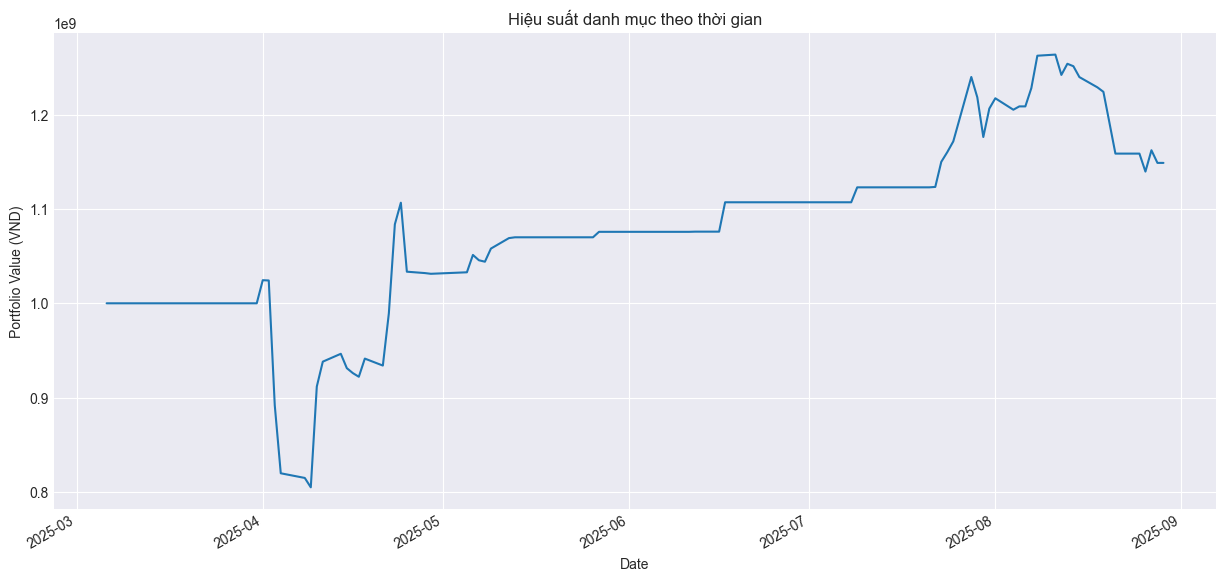

In [35]:
DATA_PATH = r"D:\Downloads\DSTC vòng 2\cleaned data\UPCOM_cleaned_last.xlsx"
MODEL_PATH = r'D:\Downloads\DSTC vòng 2\weight\best_lstm_classifier_improved.pth'
SCALER_PATH = r"D:\Downloads\DSTC vòng 2\weight\feature_scaler.pkl"

try:
    data_full = pd.read_excel(DATA_PATH)
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file dữ liệu tại: {DATA_PATH}")
    data_full = None

if data_full is not None:
    signal_model_params = {
        # ... (các tham số không đổi)
        "top_features": ['price_vs_ema200', 'volatility_20', 'volatility_10', 'volume', 'bollinger_bw', 'macd_signal', 'ema_200', 'macd_diff', 'bollinger_pct', 'rsi_lag_3', 'mfi_lag_3', 'macd', 'mfi', 'macd_diff_momentum', 'rsi'],
        "time_steps": 10, "device": "cpu", "model_path": MODEL_PATH, "scaler_path": SCALER_PATH
    }

    # <<< THAY ĐỔI: Gọi run_backtest và nhận 2 kết quả >>>
    result_df, trade_log_df = run_backtest(
        all_df=data_full,
        RiskClassifier=RiskClassifier,
        SignalClassifier=SignalClassifier,
        signal_model_params=signal_model_params
    )

    # <<< THÊM MỚI: Tải dữ liệu Benchmark và gọi hàm phân tích >>>
    if not result_df.empty:
        start_date = result_df.index[0]
        end_date = result_df.index[-1]
    
        
        analyze_performance(
            portfolio_df=result_df,
            trade_log_df=trade_log_df,
            initial_balance=1_000_000_000 
        )
        print("\n--- KẾT QUẢ BACKTEST ---")
        initial_value = result_df['value'].iloc[0]
        final_value = result_df['value'].iloc[-1]
        total_return = (final_value / initial_value - 1) * 100
        result_df['value'].plot(figsize=(15, 7), title='Hiệu suất danh mục theo thời gian')
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value (VND)")
        plt.grid(True)
        plt.show()